In [ ]:
# ---- Parameters ----
SCREEN = "20241118_AWALS35_intermediate_screen_n72"

In [ ]:
from maps.screens import ImageScreenMultiAntibody
from maps.multiantibody.config import TrainConfig, ModelConfig, DataLoaderConfig
import json
import importlib
import sys
import pandas as pd
from pathlib import Path

sys.path.append("/home/kkumbier/maps/")
import maps.multiantibody.data_loaders as data_loaders
import maps.multiantibody.models as models
import maps.multiantibody.training as training
import maps.multiantibody.evaluate as evaluate

# --- Initialize parameters ---
pdir = Path("/home/kkumbier/als/scripts/20250916_pipelines/params")
with open(pdir / "binary-split-train.json", "r") as f:
    train_params = json.load(f)

with open(pdir / "binary-split-test.json", "r") as f:
    test_params = json.load(f)

train_params["screen"] = SCREEN
test_params["screen"] = SCREEN

dataloader_config = DataLoaderConfig()
train_config = TrainConfig()
model_config = ModelConfig()
model_config.n_classes = 2

antibodies = ["FUS/EEA1"]
response_map = {"WT": 0, "FUS": 1}

In [17]:
# Load and process screens for train / test
train_screen = ImageScreenMultiAntibody(train_params)
train_screen.load(antibody=antibodies)

test_screen = ImageScreenMultiAntibody(test_params)
test_screen.load(antibody=antibodies)

print("Processing training set...")
train_screen.preprocess()

print("Processing test set...")
test_screen.preprocess()

assert train_screen.data is not None, "Loading failed"
assert test_screen.data is not None, "Loading failed"

for ab in  antibodies:
    print(f"Marker set: {ab}")
    print(f"Train data: {train_screen.data[ab].shape}")
    print(f"Test data: {test_screen.data[ab].shape}")

Processing training set...
Preprocessing complete
Processing test set...
Preprocessing complete
Marker set: FUS/EEA1
Train data: (24907, 315)
Test data: (22728, 315)


In [18]:
importlib.reload(data_loaders)
create_multiantibody_dataloader = data_loaders.create_multiantibody_dataloader

dataloader_config = DataLoaderConfig()
dataloader_config.batch_size = 8
dataloader_config.n_cells = 250
dataloader_config.response_map = {"Mutations": response_map}

train_dataloader = create_multiantibody_dataloader(
    train_screen,
    **vars(dataloader_config)
)

test_dataloader = create_multiantibody_dataloader(
    test_screen,
    scalers=train_dataloader._get_scalers(),
    **vars(dataloader_config)
)

In [19]:
importlib.reload(training)
importlib.reload(models)
importlib.reload(evaluate)

eval_model = evaluate.eval
train = training.train
MultiAntibodyClassifier = models.MultiAntibodyClassifier

# Initiaize model and train
train_config.n_epochs = 100
train_config.patience = 10
train_config.lr = 5e-3
train_config.use_contrastive_loss = True

model_config.antibody_feature_dims = train_dataloader._get_feature_dims()
model_config.d_model = 16
model_config.n_layers = 1

model_train = MultiAntibodyClassifier(**vars(model_config))
train(model_train, train_dataloader, train_config)

print("Evaluating model...")
test_dataloader.mode = "eval"
df_test, emb_test = eval_model(model_train, test_dataloader)

model_test = MultiAntibodyClassifier(**vars(model_config))
test_dataloader.mode = "train"
train(model_test, test_dataloader, train_config)

print("Evaluating model...")
train_dataloader.mode = "eval"
df_train, emb_train = eval_model(model_test, train_dataloader)

Starting cell-level training...
Cell Epoch 1/100, Overall Loss: 2.7231, Active: 1/1
  FUS/EEA1 - Loss: 0.7759, Acc: 0.4783 
Cell Epoch 2/100, Overall Loss: 2.5098, Active: 1/1
  FUS/EEA1 - Loss: 0.6909, Acc: 0.5615 
Cell Epoch 3/100, Overall Loss: 2.3615, Active: 1/1
  FUS/EEA1 - Loss: 0.6335, Acc: 0.6383 
Cell Epoch 4/100, Overall Loss: 2.3358, Active: 1/1
  FUS/EEA1 - Loss: 0.6350, Acc: 0.6523 
Cell Epoch 5/100, Overall Loss: 2.2866, Active: 1/1
  FUS/EEA1 - Loss: 0.6387, Acc: 0.6393 
Cell Epoch 6/100, Overall Loss: 2.2068, Active: 1/1
  FUS/EEA1 - Loss: 0.5838, Acc: 0.7035 
Cell Epoch 7/100, Overall Loss: 2.1579, Active: 1/1
  FUS/EEA1 - Loss: 0.6039, Acc: 0.6738 
Cell Epoch 8/100, Overall Loss: 2.1402, Active: 1/1
  FUS/EEA1 - Loss: 0.5753, Acc: 0.7088 
Cell Epoch 9/100, Overall Loss: 2.0682, Active: 1/1
  FUS/EEA1 - Loss: 0.5648, Acc: 0.7205 
Cell Epoch 10/100, Overall Loss: 2.0640, Active: 1/1
  FUS/EEA1 - Loss: 0.5633, Acc: 0.7158 
Cell Epoch 11/100, Overall Loss: 2.0059, Active

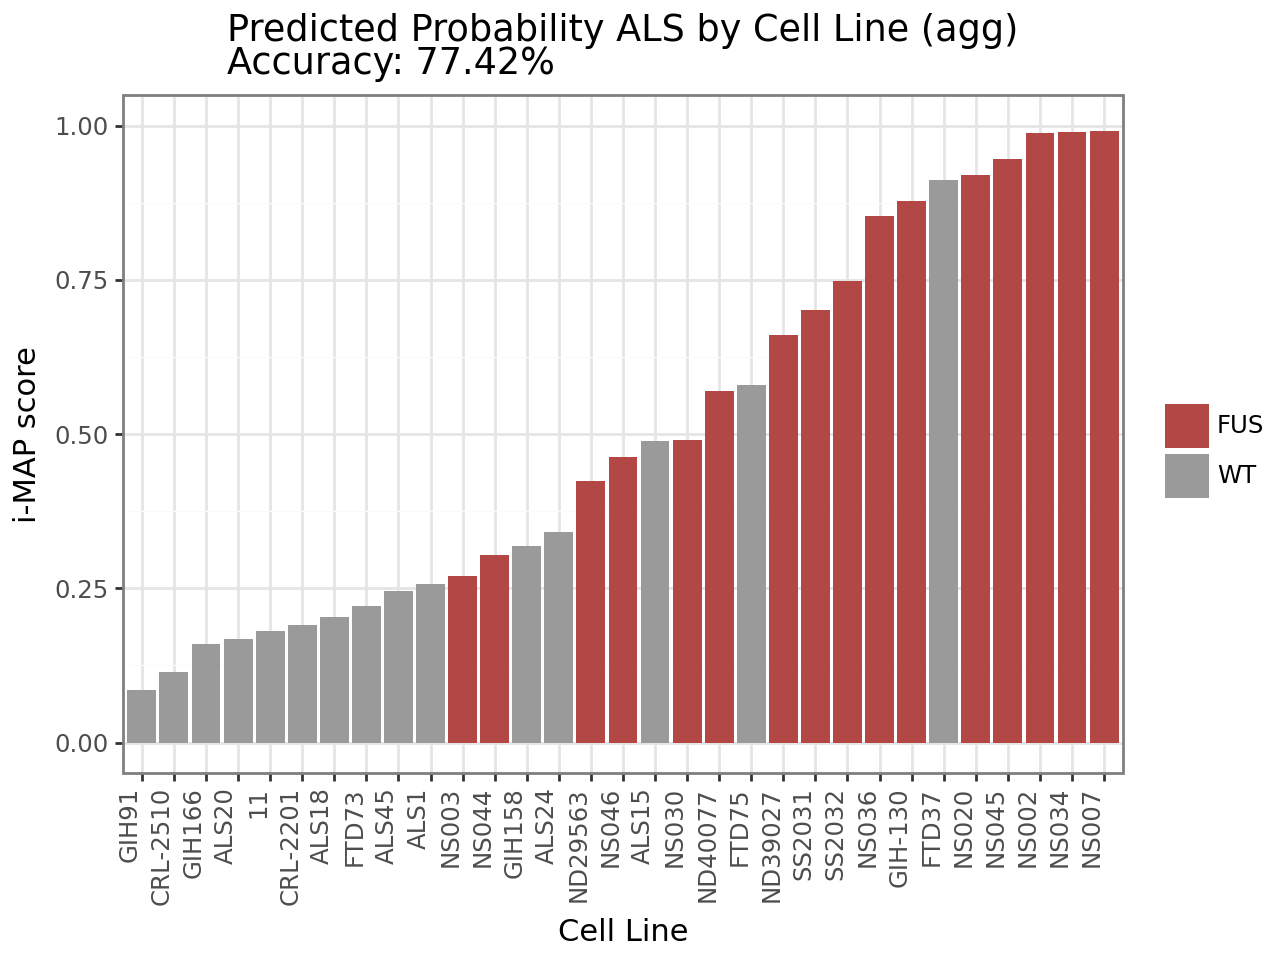

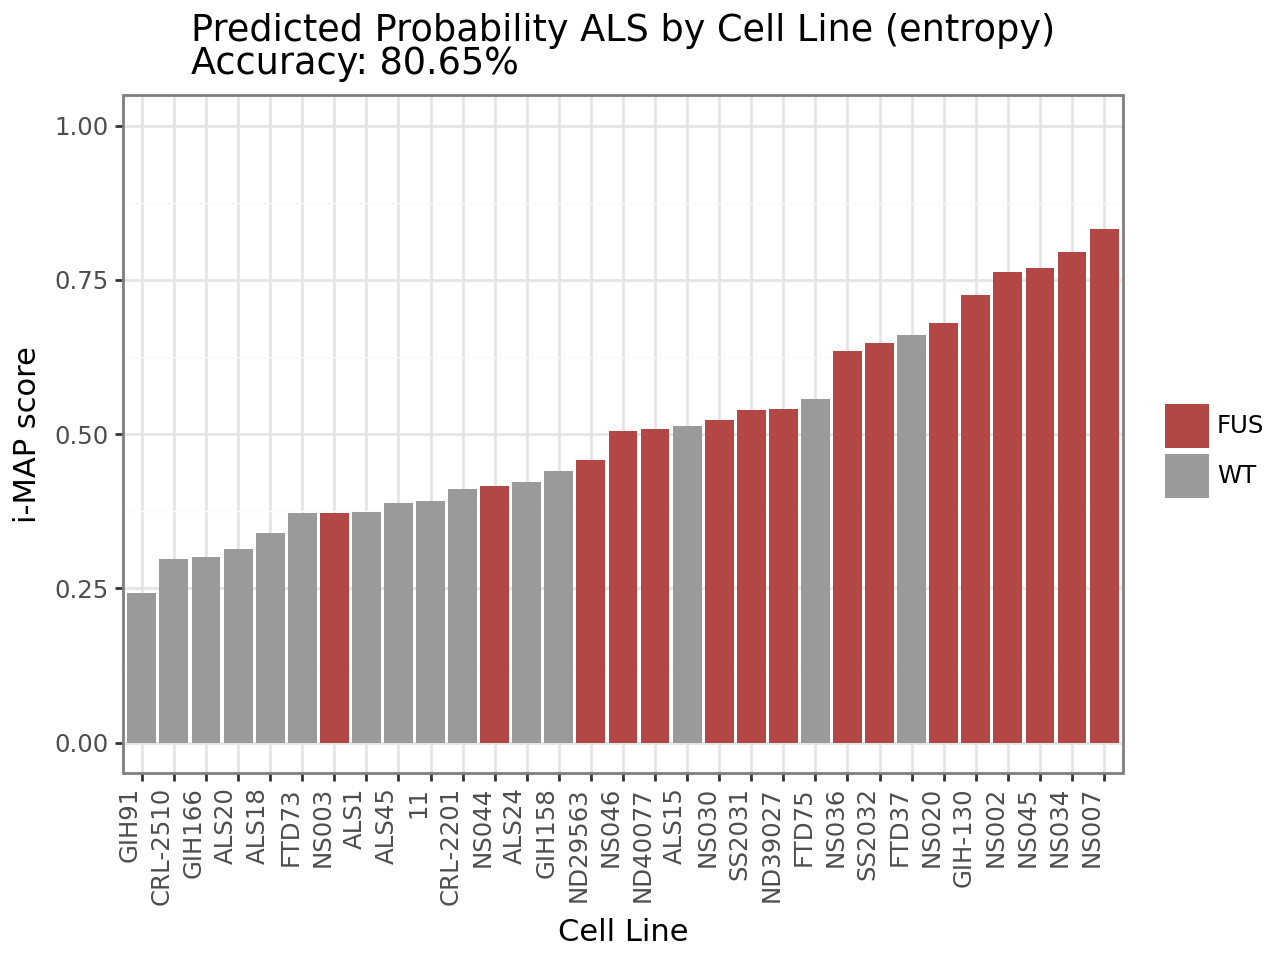

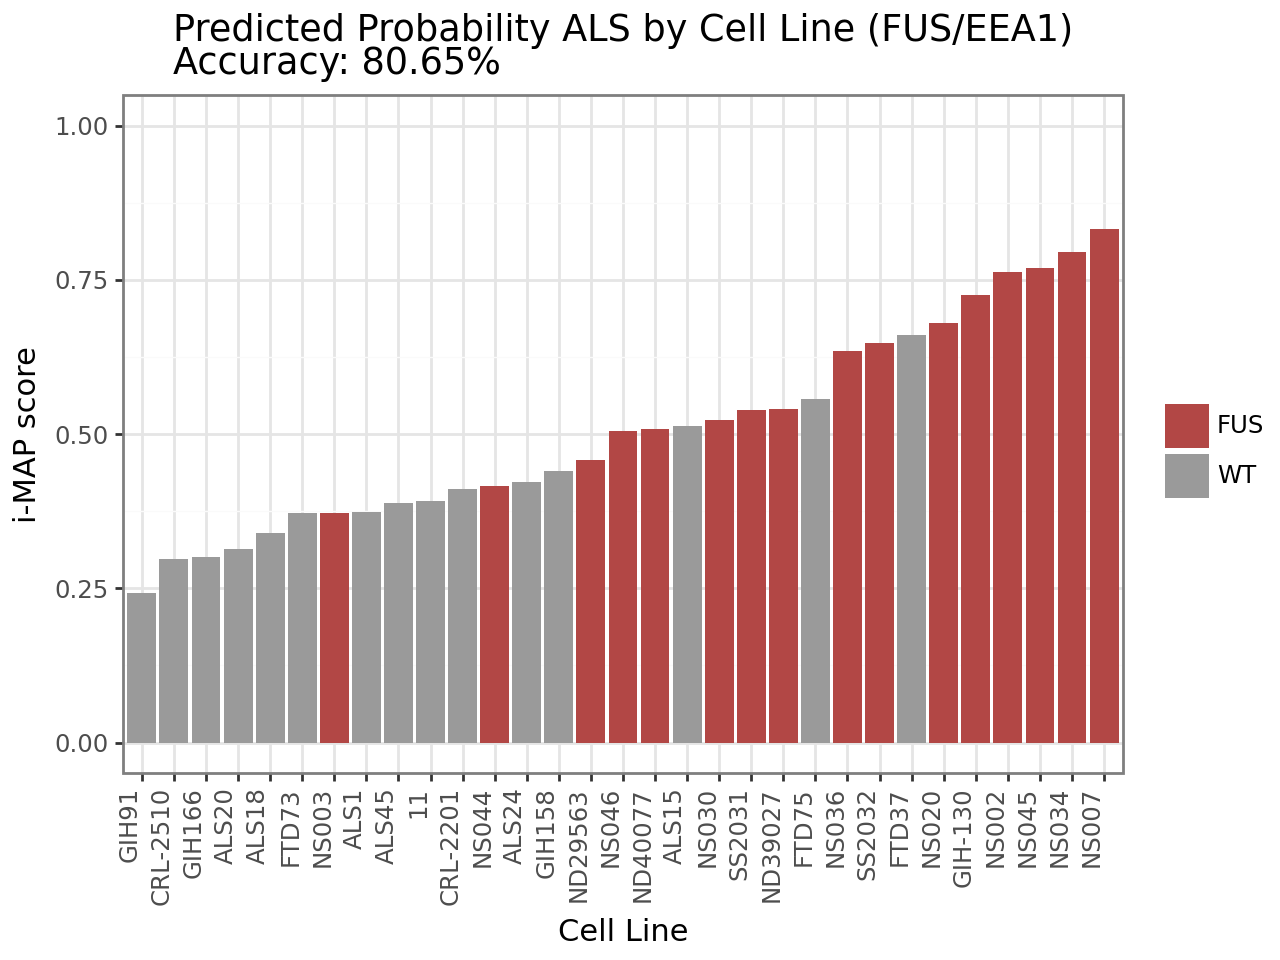

In [20]:
from IPython.display import display
from maps.figures import PALETTE

from plotnine import (
    ggplot, aes, geom_bar, theme, element_text, labs, ggtitle, scale_fill_manual, ylim, theme_bw
)

df = pd.concat([df_train, df_test])
groups = ["agg", "entropy"] + antibodies

def plot_preds(df, groups, response_map):
    for g in groups:
        # Sort preds by predicted probability (Class_1) in ascending order
        preds = df.sort_values(by=f'class_1_{g}', ascending=True)
        
        preds['CellLines'] = pd.Categorical(
            preds['CellLines'], categories=preds['CellLines'], ordered=True
        )
        
        # Compute prediction accuracy for current group
        pred_labels = (preds[f'class_1_{g}'] > 0.5)
        accuracy = (pred_labels == preds["True"]).mean()
        preds["True"] = preds["True"].map({0: "WT", 1: "FUS"})
        
        p = (
            ggplot(preds, aes(x='CellLines', y=f'class_1_{g}', fill='True')) +
            geom_bar(stat='identity') +
            theme_bw() +
            theme(axis_text_x=element_text(rotation=90, hjust=1)) +
            labs(x='Cell Line', y='i-MAP score', fill="") +
            ggtitle(
                f"Predicted Probability ALS by Cell Line ({g})\nAccuracy: {accuracy:.2%}") +
            scale_fill_manual(values=PALETTE) +
            ylim(0, 1)
        )
        display(p)
        
plot_preds(df, groups, response_map)

In [ ]:

screen = train_params["screen"]
df["Mutation"] = df["True"].map({0: "WT", 1: "FUS"})
df = df.rename(columns={"True": "TrueClass"})
df = df.rename(columns={"class_0_agg":"prob_0", "class_1_agg":"prob_1"})
df = df[["prob_0", "prob_1", "CellLines", "TrueClass", "Mutation"]]

out_dir = Path("/home/kkumbier/als/analysis_results")
out_path = out_dir / SCREEN / f"fus_v_wt.csv"
df.to_csv(out_path, index=False)